# Temporal and Semantic Clustering

This scripts calculate semantic and temporal scores for the whle FR1 dataset.
It should work for catfr too (although a category score may be more relevant than the semantic score used in this script)

In [80]:
%matplotlib inline
import cmlreaders as cml
%cd '/home1/noaherz/pybeh_pd'
import pybeh_pd as pb
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from false_memory_functions import *

/home1/noaherz/pybeh_pd


## choose experiment

In [3]:
# cml.CMLReader.load_events?
# If needed, conda install CMLReader to get the newest version (git pull for nesext version from pennmem, only then you could see the catFR data)

Choose experiment:

In [4]:
all_fr1_events = cml.CMLReader.load_events(experiments=["FR1"])
# all_fr1_events = cml.CMLReader.load_events(experiments=["catFR1"],data_type='task_events')

In [5]:
events = all_fr1_events.query('type == ["WORD", "REC_WORD"]')
events.rename(columns={'item_name': 'item'}, inplace=True)
events = events[events['list'] > 0]
word_evs = events.query('type == "WORD"')
rec_evs = events.query('type == "REC_WORD"')

#removing subjects who were presented with the same word multiple times (probably repeated data)
n_word_pres = word_evs.groupby(['subject', 'session', 'list', 'item_num']).size().to_frame(name='n').reset_index()
bad_lists = n_word_pres.query('n > 2')
bad_lists[['subject', 'session', 'list']].drop_duplicates()
bad_subs = bad_lists.subject.unique().tolist()
bad_subs = bad_subs + ["R1171M", "R1093J", "R1329T", "R1341T", "R1015J"] #"R1015J" had no recalls, other subjects unsure...
events.query('subject not in @bad_subs', inplace=True)

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
events.head(5)

,answer,eegfile,eegoffset,exp_version,experiment,intrusion,is_stim,iscorrect,item,item_num,...,recognized,rectime,rejected,serialpos,session,stim_list,stim_params,subject,test,type
26,-999,R1001P_FR1_0_12Oct14_1034,388959,1.02,FR1,-999,0,-999,HOUSE,130,...,NaN,-999,NaN,1,0,0,[],R1001P,"[0, 0, 0]",WORD
27,-999,R1001P_FR1_0_12Oct14_1034,390268,1.02,FR1,-999,0,-999,HAWK,120,...,NaN,-999,NaN,2,0,0,[],R1001P,"[0, 0, 0]",WORD
28,-999,R1001P_FR1_0_12Oct14_1034,391560,1.02,FR1,-999,0,-999,WAND,288,...,NaN,-999,NaN,3,0,0,[],R1001P,"[0, 0, 0]",WORD
29,-999,R1001P_FR1_0_12Oct14_1034,392785,1.02,FR1,-999,0,-999,GEESE,110,...,NaN,-999,NaN,4,0,0,[],R1001P,"[0, 0, 0]",WORD
30,-999,R1001P_FR1_0_12Oct14_1034,394019,1.02,FR1,-999,0,-999,STAR,247,...,NaN,-999,NaN,5,0,0,[],R1001P,"[0, 0, 0]",WORD


##  temporal clustering

In [7]:
pb_crp = events.groupby('subject').apply(pb.pd_crp, 
                                itemno_column='item_num').reset_index()

I can add one more column to the data frame (e.g. BDI) 
and then add 'hue' to the above plot to seperate the results 
for the low and high depression groups

In [8]:
# load
import pickle
with open('/home1/noaherz/Mental_health5/results/df_master','rb') as pickle_file:
    df_master=pickle.load(pickle_file)
df_master

,BAI,BDI,ELIs,IQ,IQ_type,PLIs,TBI_notes,age_at_implant,age_of_seizure_onset,all recalls,...,gender,implant_date,lists,prior_neurosurgical_procedures,reimplant_date,session,site,subject,total ints,years_of_education
0,8.0,2.0,21.0,72.0,FSIQ4,25.0,NaN,48.105026,20.0,108.0,...,Female,2014-10-08,22.0,NaN,NaT,0.0,University of Pennsylvania,R1001P,46.0,13.0
1,8.0,2.0,19.0,72.0,FSIQ4,17.0,NaN,48.105026,20.0,99.0,...,Female,2014-10-08,23.0,NaN,NaT,1.0,University of Pennsylvania,R1001P,36.0,13.0
2,9.0,0.0,3.0,86.0,FSIQ4,8.0,NaN,49.383743,34.0,128.0,...,Female,2014-11-12,25.0,NaN,NaT,0.0,University of Pennsylvania,R1002P,11.0,16.0
3,9.0,0.0,2.0,86.0,FSIQ4,3.0,NaN,49.383743,34.0,125.0,...,Female,2014-11-12,25.0,NaN,NaT,1.0,University of Pennsylvania,R1002P,5.0,16.0
4,NaN,NaN,30.0,102.0,FSIQ4,26.0,motor vehicle accident due to loss of consciou...,39.390382,37.0,142.0,...,Female,2014-11-13,22.0,NaN,NaT,0.0,University of Pennsylvania,R1003P,56.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,NaN,NaN,6.0,89.0,FSIQ4,1.0,NaN,41.243717,34.0,31.0,...,Female,2021-06-28,9.0,NaN,NaT,0.0,UT Southwestern,R1565T,7.0,18.0
1103,NaN,NaN,16.0,89.0,FSIQ4,18.0,NaN,22.573929,19.0,102.0,...,Female,2021-07-05,25.0,NaN,NaT,0.0,UT Southwestern,R1569T,34.0,NaN
1104,NaN,NaN,11.0,87.0,FSIQ4,18.0,NaN,31.283325,17.0,106.0,...,Male,2021-07-19,24.0,NaN,NaT,0.0,UT Southwestern,R1571T,29.0,NaN
1105,6.0,10.0,4.0,84.0,FSIQ4,4.0,NaN,35.820037,23.0,23.0,...,Female,2021-07-20,5.0,NaN,NaT,0.0,UT Southwestern,R1572T,8.0,NaN


In [9]:
# pd.concat([df_master, pb_crp], join="inner", ignore_index=True)
combined_df=pd.merge(df_master[['BAI','BDI','subject']], pb_crp, on=['subject'], how='left')
combined_df=combined_df.dropna(subset=['BAI', 'BDI'])
combined_df

,BAI,BDI,subject,level_1,prob,lag
0,8.0,2.0,R1001P,-5.0,0.103448,-5.0
1,8.0,2.0,R1001P,-4.0,0.000000,-4.0
2,8.0,2.0,R1001P,-3.0,0.105263,-3.0
3,8.0,2.0,R1001P,-2.0,0.025641,-2.0
4,8.0,2.0,R1001P,-1.0,0.121951,-1.0
...,...,...,...,...,...,...
9431,6.0,10.0,R1572T,1.0,0.000000,1.0
9432,6.0,10.0,R1572T,2.0,0.000000,2.0
9433,6.0,10.0,R1572T,3.0,0.000000,3.0
9434,6.0,10.0,R1572T,4.0,0.000000,4.0


Plot data across all participants

In [16]:
assert(~np.any(np.isnan(combined_df['BAI'])))
assert(~np.any(np.isnan(combined_df['BDI'])))

In [64]:
fig_path='/home1/noaherz/Mental_health5/figures'

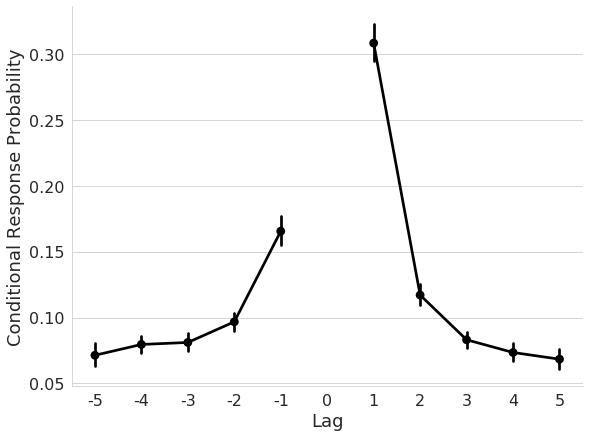

In [95]:
# Plot
# plt.figure(figsize=(8,4))
sns.set_style("whitegrid")

g = sns.catplot(x='lag', y='prob', kind='point',color='black',height=6, aspect=8/6,
                  data=combined_df.query('lag <= 5 and lag >= -5'))
g.set_xlabels('Lag', fontsize=18)
g.set_ylabels('Conditional Response Probability', fontsize=18)
plt.xticks(np.arange(11),(-5,-4,-3,-2,-1,0,1,2,3,4,5),fontsize=16)
plt.yticks(fontsize=16)

plt.savefig(f"{fig_path}/lag_crp.pdf",transparent=True,bbox_inches='tight', pad_inches=0.08, format='pdf')


#### Split BDI/BAI scores to high/low

In [66]:
# median split
median_BAI=np.median(combined_df['BAI'])
median_BDI=np.median(combined_df['BDI'])
combined_df['high_anxiety']=combined_df['BAI']>median_BAI
combined_df['high_depression']=combined_df['BDI']>median_BDI

# use tercile instead:
low_BAI=np.percentile(combined_df['BAI'],1/3*100)
low_BDI=np.percentile(combined_df['BDI'],1/3*100)
upper_BAI=np.percentile(combined_df['BAI'],2/3*100)
upper_BDI=np.percentile(combined_df['BDI'],2/3*100)

# anxiety groups
combined_df['anxiety_tercile']='mid'
low_BAI_index=combined_df[combined_df['BAI']<low_BAI].index
combined_df['anxiety_tercile'][low_BAI_index]='Low'
high_BAI_index=combined_df[combined_df['BAI']>upper_BAI].index
combined_df['anxiety_tercile'][high_BAI_index]='high'

# depression groups
combined_df['depression_tercile']='mid'
low_BDI_index=combined_df[combined_df['BDI']<low_BDI].index
combined_df['depression_tercile'][low_BDI_index]='Low'
high_BDI_index=combined_df[combined_df['BDI']>upper_BDI].index
combined_df['depression_tercile'][high_BDI_index]='high'
combined_df

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home1/noaherz/.conda

,BAI,BDI,subject,level_1,prob,lag,high_anxiety,high_depression,anxiety_tercile,depression_tercile
0,8.0,2.0,R1001P,-5.0,0.103448,-5.0,True,False,mid,Low
1,8.0,2.0,R1001P,-4.0,0.000000,-4.0,True,False,mid,Low
2,8.0,2.0,R1001P,-3.0,0.105263,-3.0,True,False,mid,Low
3,8.0,2.0,R1001P,-2.0,0.025641,-2.0,True,False,mid,Low
4,8.0,2.0,R1001P,-1.0,0.121951,-1.0,True,False,mid,Low
...,...,...,...,...,...,...,...,...,...,...
9431,6.0,10.0,R1572T,1.0,0.000000,1.0,False,True,mid,mid
9432,6.0,10.0,R1572T,2.0,0.000000,2.0,False,True,mid,mid
9433,6.0,10.0,R1572T,3.0,0.000000,3.0,False,True,mid,mid
9434,6.0,10.0,R1572T,4.0,0.000000,4.0,False,True,mid,mid


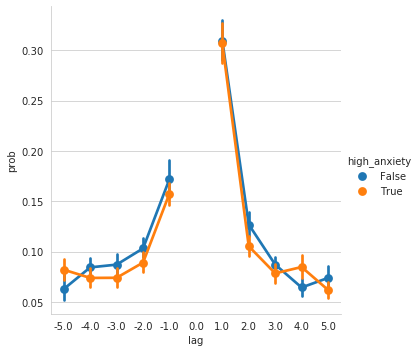

In [67]:
g = sns.catplot(x='lag', y='prob', kind='point', hue = 'high_anxiety',
                  data=combined_df.query('lag <= 5 and lag >= -5')
           )

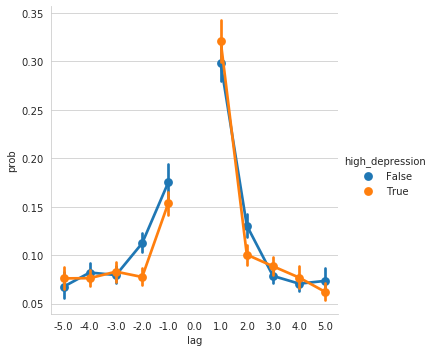

In [68]:
g = sns.catplot(x='lag', y='prob', kind='point', hue = 'high_depression',
                  data=combined_df.query('lag <= 5 and lag >= -5')
           )

calculate temporal factor

In [69]:
pb_temp_fact = events.groupby(['subject', 'session']).apply(pb.pd_temp_fact,
                                                   itemno_column='item_num', 
                                                   list_index=['subject', 'session', 'list'], 
                                                   pres_type="WORD", rec_type="REC_WORD", type_column='type'#, ret_counts=False,
                                                   ).to_frame(name='temp_fact').reset_index()

pb_temp_fact

,subject,session,temp_fact
0,R1001P,0,0.626542
1,R1001P,1,0.624477
2,R1002P,0,0.631378
3,R1002P,1,0.574718
4,R1003P,0,0.522927
...,...,...,...
566,R1565T,0,0.926068
567,R1569T,0,0.758442
568,R1571T,0,0.741228
569,R1572T,0,0.395809


#### combine temporal_factor with BAI/BDI scores

In [70]:
combined_temp_df=pd.merge(df_master[['BAI','BDI','subject','session','gender','IQ','age_at_implant','binary_prior_neuro']], pb_temp_fact, on=['subject','session'], how='right')
combined_temp_df = combined_temp_df.dropna(subset=['BAI','BDI','temp_fact'])
# combined_temp_df = combined_temp_df[combined_temp_df['session']==0] # reduce multiple rows for seperate sessions
combined_temp_df
# combined_temp_df.drop(columns='session')

,BAI,BDI,subject,session,gender,IQ,age_at_implant,binary_prior_neuro,temp_fact
0,8.0,2.0,R1001P,0.0,Female,72.0,48.105026,1.0,0.626542
1,8.0,2.0,R1001P,1.0,Female,72.0,48.105026,1.0,0.624477
2,9.0,0.0,R1002P,0.0,Female,86.0,49.383743,1.0,0.631378
3,9.0,0.0,R1002P,1.0,Female,86.0,49.383743,1.0,0.574718
6,7.0,7.0,R1006P,0.0,Female,83.0,20.553582,1.0,0.673545
...,...,...,...,...,...,...,...,...,...
747,2.0,7.0,R1542J,2.0,Male,114.0,29.281915,0.0,0.539026
748,2.0,7.0,R1542J,3.0,Male,114.0,29.281915,0.0,0.546418
749,2.0,7.0,R1542J,4.0,Male,114.0,29.281915,0.0,0.576503
750,2.0,7.0,R1542J,5.0,Male,114.0,29.281915,0.0,0.538109


#### Compute one-sample t-test to determine difference from 0

Add low/high median split

In [71]:
# median
median_BAI=np.median(combined_temp_df['BAI'])
median_BDI=np.median(combined_temp_df['BDI'])
combined_temp_df['high_anxiety']=combined_temp_df['BAI']>median_BAI
combined_temp_df['high_depression']=combined_temp_df['BDI']>median_BDI

# or terciles:
low_BAI=np.percentile(combined_temp_df['BAI'],1/3*100)
low_BDI=np.percentile(combined_temp_df['BDI'],1/3*100)
upper_BAI=np.percentile(combined_temp_df['BAI'],2/3*100)
upper_BDI=np.percentile(combined_temp_df['BDI'],2/3*100)

# anxiety groups
combined_temp_df['anxiety_tercile']='mid'
low_BAI_index=combined_temp_df[combined_temp_df['BAI']<low_BAI].index
combined_temp_df['anxiety_tercile'][low_BAI_index]='low'
high_BAI_index=combined_temp_df[combined_temp_df['BAI']>upper_BAI].index
combined_temp_df['anxiety_tercile'][high_BAI_index]='high'

# depression groups
combined_temp_df['depression_tercile']='mid'
low_BDI_index=combined_temp_df[combined_temp_df['BDI']<low_BDI].index
combined_temp_df['depression_tercile'][low_BDI_index]='low'
high_BDI_index=combined_temp_df[combined_temp_df['BDI']>upper_BDI].index
combined_temp_df['depression_tercile'][high_BDI_index]='high'
combined_temp_df

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home1/noaherz/.conda

,BAI,BDI,subject,session,gender,IQ,age_at_implant,binary_prior_neuro,temp_fact,high_anxiety,high_depression,anxiety_tercile,depression_tercile
0,8.0,2.0,R1001P,0.0,Female,72.0,48.105026,1.0,0.626542,True,False,mid,low
1,8.0,2.0,R1001P,1.0,Female,72.0,48.105026,1.0,0.624477,True,False,mid,low
2,9.0,0.0,R1002P,0.0,Female,86.0,49.383743,1.0,0.631378,True,False,mid,low
3,9.0,0.0,R1002P,1.0,Female,86.0,49.383743,1.0,0.574718,True,False,mid,low
6,7.0,7.0,R1006P,0.0,Female,83.0,20.553582,1.0,0.673545,False,False,mid,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,2.0,7.0,R1542J,2.0,Male,114.0,29.281915,0.0,0.539026,False,False,low,mid
748,2.0,7.0,R1542J,3.0,Male,114.0,29.281915,0.0,0.546418,False,False,low,mid
749,2.0,7.0,R1542J,4.0,Male,114.0,29.281915,0.0,0.576503,False,False,low,mid
750,2.0,7.0,R1542J,5.0,Male,114.0,29.281915,0.0,0.538109,False,False,low,mid


Average over sessions

In [72]:
mean_temp=combined_temp_df.groupby('subject')['temp_fact'].transform('mean') # avg over session within subjects
combined_temp_df['mean_temp'] = mean_temp
# combined_temp_df[combined_temp_df['subject']]
combined_temp_df

,BAI,BDI,subject,session,gender,IQ,age_at_implant,binary_prior_neuro,temp_fact,high_anxiety,high_depression,anxiety_tercile,depression_tercile,mean_temp
0,8.0,2.0,R1001P,0.0,Female,72.0,48.105026,1.0,0.626542,True,False,mid,low,0.625510
1,8.0,2.0,R1001P,1.0,Female,72.0,48.105026,1.0,0.624477,True,False,mid,low,0.625510
2,9.0,0.0,R1002P,0.0,Female,86.0,49.383743,1.0,0.631378,True,False,mid,low,0.603048
3,9.0,0.0,R1002P,1.0,Female,86.0,49.383743,1.0,0.574718,True,False,mid,low,0.603048
6,7.0,7.0,R1006P,0.0,Female,83.0,20.553582,1.0,0.673545,False,False,mid,mid,0.675457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,2.0,7.0,R1542J,2.0,Male,114.0,29.281915,0.0,0.539026,False,False,low,mid,0.577039
748,2.0,7.0,R1542J,3.0,Male,114.0,29.281915,0.0,0.546418,False,False,low,mid,0.577039
749,2.0,7.0,R1542J,4.0,Male,114.0,29.281915,0.0,0.576503,False,False,low,mid,0.577039
750,2.0,7.0,R1542J,5.0,Male,114.0,29.281915,0.0,0.538109,False,False,low,mid,0.577039


leave only one value per participnat

In [73]:
sub_level_df = pd.DataFrame([])
for sub in combined_temp_df['subject'].unique():
    sub_inf = combined_temp_df[combined_temp_df['subject']==sub]
    sub_level_df = sub_level_df.append({'subject':sub_inf['subject'].iloc[0],'high_anxiety':sub_inf['high_anxiety'].iloc[0],
                           'high_depression':sub_inf['high_depression'].iloc[0],'anxiety_tercile':sub_inf['anxiety_tercile'].iloc[0],
                                        'depression_tercile':sub_inf['depression_tercile'].iloc[0],'BDI':sub_inf['BDI'].iloc[0],
                                        'BAI':sub_inf['BAI'].iloc[0],'mean_temp':sub_inf['mean_temp'].iloc[0]},ignore_index=True)
sub_level_df

,BAI,BDI,anxiety_tercile,depression_tercile,high_anxiety,high_depression,mean_temp,subject
0,8.0,2.0,mid,low,1.0,0.0,0.625510,R1001P
1,9.0,0.0,mid,low,1.0,0.0,0.603048,R1002P
2,7.0,7.0,mid,mid,0.0,0.0,0.675457,R1006P
3,2.0,1.0,low,low,0.0,0.0,0.602108,R1010J
4,0.0,2.0,low,low,0.0,0.0,0.666148,R1018P
...,...,...,...,...,...,...,...,...
81,5.0,4.0,mid,low,0.0,0.0,0.570469,R1443D
82,6.0,0.0,mid,low,0.0,0.0,0.543179,R1457T
83,14.0,20.0,high,high,1.0,1.0,0.654820,R1466J
84,2.0,7.0,low,mid,0.0,0.0,0.577039,R1542J


#### Plot bar graph of temporal factor

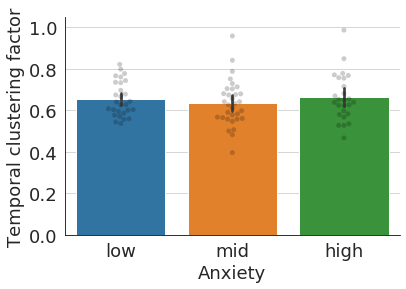

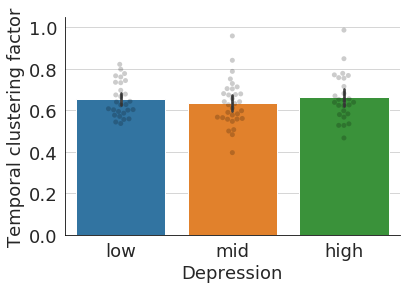

In [74]:
# Anxiety
plt.figure(figsize=(6,4))

# sort values
anxiety_terciles_categories = ['low','mid','high']
# Make "depression_tercile" a proper categorical column, specifying the categories and their order
sub_level_df["anxiety_tercile"] = pd.Categorical(sub_level_df["depression_tercile"], categories=anxiety_terciles_categories)

sub_level_df.sort_values(by = "anxiety_tercile",inplace=True, ascending = False) # sort categorized alphabetically
# Reset the index after sorting
sub_level_df.reset_index(drop=True, inplace=True)


sns.barplot(data = sub_level_df
            ,x = 'anxiety_tercile' ,y = 'mean_temp',order = ['low','mid','high'])
sns.swarmplot(data=sub_level_df,x = 'anxiety_tercile'
            ,y = 'mean_temp',color="0",alpha=.2)

# sns.swarmplot(data=combined_df,color="0",alpha=.4)
plt.ylabel('Temporal clustering factor',fontsize=18)
plt.xlabel('Anxiety',fontsize=18)
plt.xticks(fontsize=18);plt.yticks(fontsize=18)
# ax.set_ylim(-0.3, 0.4)
# sns.despine()
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['bottom'].set_color('k')

# Depression
plt.figure(figsize=(6,4))
# sort values
depression_terciles_categories = ['low','mid','high']
# Make "depression_tercile" a proper categorical column, specifying the categories and their order
sub_level_df["depression_tercile"] = pd.Categorical(sub_level_df["depression_tercile"], categories=depression_terciles_categories)

sub_level_df.sort_values(by = "depression_tercile",inplace=True, ascending = False) # sort categorized alphabetically
# Reset the index after sorting
sub_level_df.reset_index(drop=True, inplace=True)

#Plot
sns.barplot(data = sub_level_df
            ,x = 'depression_tercile' ,y = 'mean_temp',order = ['low','mid','high'])
sns.swarmplot(data=sub_level_df,x = 'depression_tercile'
            ,y = 'mean_temp',color="0",alpha=.2)

# sns.swarmplot(data=combined_df,color="0",alpha=.4)
plt.ylabel('Temporal clustering factor',fontsize=18)
plt.xlabel('Depression',fontsize=18)
plt.xticks(fontsize=18);plt.yticks(fontsize=18)
# ax.set_ylim(-0.3, 0.4)
# sns.despine()
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['bottom'].set_color('k')

#### Plot simple correlation between anxiety/depression and temporal factor

anxiety: r= -0.08358529924268193  p=  0.444190645855117
depression: r= -0.016640789570582105  p=  0.8791296231318171


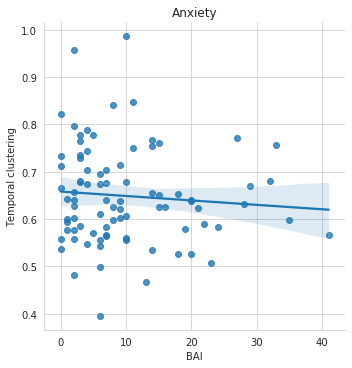

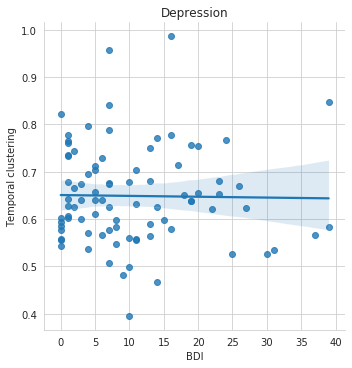

In [75]:
# anxiety
sns.lmplot(x="BAI", y="mean_temp", data=sub_level_df);
ax = plt.gca()
ax.set_title("Anxiety")
ax.set( xlabel = "BAI", ylabel = "Temporal clustering")

r, p= stats.pearsonr(sub_level_df['BAI'], sub_level_df['mean_temp'])
print('anxiety: r=', r, ' p= ',p)

# Depression
sns.lmplot(x="BDI", y="mean_temp", data=sub_level_df);
ax = plt.gca()
ax.set_title("Depression")
ax.set( xlabel = "BDI", ylabel = "Temporal clustering")

r, p= stats.pearsonr(sub_level_df['BDI'], sub_level_df['mean_temp'])
print('depression: r=', r, ' p= ',p)

Plot correlation between variables and models' residuals : https://www.pythonfordatascience.org/mixed-effects-regression-python/


In [76]:
demog_df = combined_temp_df.dropna(subset=['gender','binary_prior_neuro', 'age_at_implant', 'IQ'])
demog_df.head(5)


,BAI,BDI,subject,session,gender,IQ,age_at_implant,binary_prior_neuro,temp_fact,high_anxiety,high_depression,anxiety_tercile,depression_tercile,mean_temp
0,8.0,2.0,R1001P,0.0,Female,72.0,48.105026,1.0,0.626542,True,False,mid,low,0.625510
1,8.0,2.0,R1001P,1.0,Female,72.0,48.105026,1.0,0.624477,True,False,mid,low,0.625510
2,9.0,0.0,R1002P,0.0,Female,86.0,49.383743,1.0,0.631378,True,False,mid,low,0.603048
3,9.0,0.0,R1002P,1.0,Female,86.0,49.383743,1.0,0.574718,True,False,mid,low,0.603048
6,7.0,7.0,R1006P,0.0,Female,83.0,20.553582,1.0,0.673545,False,False,mid,mid,0.675457


Delete

In [77]:
sub_level_df = pd.DataFrame([])
for sub in combined_temp_df['subject'].unique():
    sub_inf = combined_temp_df[combined_temp_df['subject']==sub]
    sub_level_df = sub_level_df.append({'subject':sub_inf['subject'].iloc[0],'high_anxiety':sub_inf['high_anxiety'].iloc[0],
                           'high_depression':sub_inf['high_depression'].iloc[0],'anxiety_tercile':sub_inf['anxiety_tercile'].iloc[0],
                                        'depression_tercile':sub_inf['depression_tercile'].iloc[0],'BDI':sub_inf['BDI'].iloc[0],
                                        'BAI':sub_inf['BAI'].iloc[0],'mean_temp':sub_inf['mean_temp'].iloc[0],
                                       'gender':sub_inf['gender'].iloc[0],
                                       'binary_prior_neuro':sub_inf['binary_prior_neuro'].iloc[0],
                                       'age_at_implant':sub_inf['age_at_implant'].iloc[0],
                                       'IQ':sub_inf['IQ'].iloc[0]},ignore_index=True)
sub_level_df

,BAI,BDI,IQ,age_at_implant,anxiety_tercile,binary_prior_neuro,depression_tercile,gender,high_anxiety,high_depression,mean_temp,subject
0,8.0,2.0,72.0,48.105026,mid,1.0,low,Female,1.0,0.0,0.625510,R1001P
1,9.0,0.0,86.0,49.383743,mid,1.0,low,Female,1.0,0.0,0.603048,R1002P
2,7.0,7.0,83.0,20.553582,mid,1.0,mid,Female,0.0,0.0,0.675457,R1006P
3,2.0,1.0,92.0,30.801454,low,1.0,low,Female,0.0,0.0,0.602108,R1010J
4,0.0,2.0,75.0,47.727309,low,1.0,low,Male,0.0,0.0,0.666148,R1018P
...,...,...,...,...,...,...,...,...,...,...,...,...
81,5.0,4.0,85.0,34.513942,mid,1.0,low,Male,0.0,0.0,0.570469,R1443D
82,6.0,0.0,76.0,51.352184,mid,0.0,low,Female,0.0,0.0,0.543179,R1457T
83,14.0,20.0,NaN,22.201802,high,1.0,high,Female,1.0,1.0,0.654820,R1466J
84,2.0,7.0,114.0,29.281915,low,0.0,mid,Male,0.0,0.0,0.577039,R1542J


In [78]:
sub_level_df=sub_level_df.dropna(subset=['gender','binary_prior_neuro','age_at_implant','IQ','mean_temp','BDI'])

### Run regular linear regression to see correlation plot

                            OLS Regression Results                            
Dep. Variable:              mean_temp   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     2.595
Date:                Thu, 01 Sep 2022   Prob (F-statistic):             0.0427
Time:                        10:24:20   Log-Likelihood:                 81.043
No. Observations:                  83   AIC:                            -152.1
Df Residuals:                      78   BIC:                            -140.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


depression: r= -0.11033380290206315  p=  0.3207196222775086


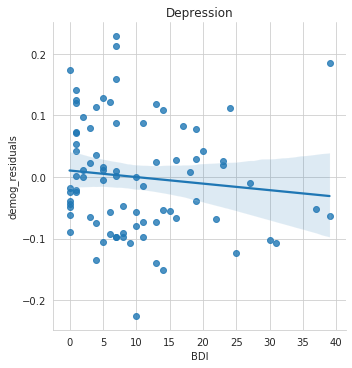

In [81]:
# create linear regression object

# only demographics
regression_demog_model=sm.OLS.from_formula('mean_temp ~ C(gender)+C(binary_prior_neuro) + age_at_implant + IQ', data=sub_level_df)
result_demog=regression_demog_model.fit()
print(result_demog.summary())

# demographics AND depression
regression_full_model=sm.OLS.from_formula('mean_temp ~ C(gender)+C(binary_prior_neuro) + age_at_implant + IQ + BDI', data=sub_level_df)
result_full=regression_full_model.fit()
print(result_full.summary())

# extract predicted values from demographic model
demog_predicted_val=result_demog.predict()

# or extract residulas instead
# demog_residuals = sub_level_df['mean_temp'] - demog_predicted_val
demog_residuals = result_demog.resid

sub_level_df['demog_predicted_val']=demog_predicted_val
sub_level_df['demog_residuals'] = demog_residuals
# plot
# Depression
sns.lmplot(x="BDI", y="demog_residuals", data=sub_level_df);
ax = plt.gca()
ax.set_title("Depression")
ax.set( xlabel = "BDI", ylabel = "demog_residuals")

r, p= stats.pearsonr(sub_level_df['BDI'], sub_level_df['demog_residuals'])
print('depression: r=', r, ' p= ',p)


In [84]:
# Sanity chack
# the b (slope) should be = r*(SD of y)/(SD of x)
-0.11033380290206315 * (np.std(demog_residuals))/(np.std(sub_level_df['BDI']))
# -0.11033380290206315 * (np.std(demog_predicted_val))/(np.std(sub_level_df['BDI']))

-0.0010623931223744984

### plot correlation between lmm models' residuals and depression

In [85]:
combined_temp_df=combined_temp_df.dropna(subset=['gender','binary_prior_neuro','age_at_implant','IQ','mean_temp'])


In [86]:
import statsmodels.api as sm
vc = {'session': '0 + C(session)'} #the vc formula always varies within the groups parameter, so it will vary within subject 

## predict temporal factor using an empty model (intercept only) :
empty_model = sm.MixedLM.from_formula('mean_temp ~ 1', vc_formula=vc,re_formula = '1' , groups='subject', data=combined_temp_df) 
result_empty=empty_model.fit(reml=True)#, method='nm')
# print(result_demog.summary())

## predict temporal factor using demographics alone:
model_demoog = sm.MixedLM.from_formula('mean_temp ~ C(gender)+C(binary_prior_neuro) + age_at_implant + IQ', vc_formula=vc,re_formula = '1' , groups='subject', data=combined_temp_df) 
result_demog=model_demoog.fit(reml=True)#, method='nm')
# print(result_demog.summary())



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     mean_temp
No. Observations:       253         Method:                 REML     
No. Groups:             83          Scale:                  0.0000   
Min. group size:        1           Log-Likelihood:         1163.4352
Max. group size:        10          Converged:              Yes      
Mean group size:        3.0                                          
---------------------------------------------------------------------
                             Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                    0.405    0.045 8.972 0.000  0.316  0.493
C(gender)[T.Male]            0.025    0.012 2.109 0.035  0.002  0.048
C(binary_prior_neuro)[T.1.0] 0.008    0.014 0.540 0.589 -0.020  0.035
age_at_implant               0.002    0.001 3.542 0.000  0.001  0.003
IQ                           0.002  

 extract predicted values from the demogrpahic model

In [91]:
# predicted values
combined_temp_df['predicted']=result_demog.fittedvalues

# residuals (for some reason there isn't much variablity here, so I used predicted values instead)
# re = result_demog.random_effects

# manual_residuals=result_demog.fittedvalues - combined_temp_df['mean_temp']
# combined_temp_df['demog_residuals'] = manual_residuals
combined_temp_df['demog_residuals'] = result_demog.resid.values


/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Plot

In [ ]:
# Depression
g=sns.lmplot(x="BDI", y="demog_residuals", data=combined_temp_df);
ax = plt.gca()
# sns.plt.ylim(-0.0025,0.0025)
# g.set(ylim=(-0.0001, 0.0001))
ax.set_title("Depression")
ax.set( xlabel = "BDI", ylabel = "Temporal Clustering (residuals)")

r, p= stats.pearsonr(combined_temp_df['BDI'], combined_temp_df['demog_residuals'])
print('depression: r=', r, ' p= ',p)


# Depression
g=sns.lmplot(x="BDI", y="predicted", data=combined_temp_df);
r, p= stats.pearsonr(combined_temp_df['BDI'], combined_temp_df['predicted'])
print('depression: r=', r, ' p= ',p)

ax = plt.gca()
# sns.plt.ylim(-0.0025,0.0025)
# g.set(ylim=(-0.0001, 0.0001))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Temporal Clustering',fontsize=22)
plt.xlabel('BDI',fontsize=22)

ax.set_title("Depression")
ax.set( xlabel = "BDI", ylabel = "Temporal Clustering (predicted)")


# plt.savefig(f"{fig_path}/corr_BDI_predicted_TempFact.pdf",transparent=True,bbox_inches='tight', pad_inches=0.08, format='pdf')


Plot residuals

Text(0.5, 0, 'Residuals')

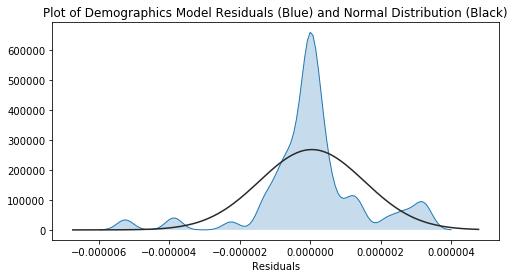

In [159]:
# DEMOGRPAHICS
fig = plt.figure(figsize = (8, 4))
ax = sns.distplot(result_demog.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)
ax.set_title("Plot of Demographics Model Residuals (Blue) and Normal Distribution (Black)")
ax.set_xlabel("Residuals")


In [163]:

# Total number of intrusions:
model = sm.MixedLM.from_formula('temp_fact ~ 1',  vc_formula=vc, groups='subject', data=demog_df) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

# demographis variables - main effect
# binary_prior_neuro is 'True' when prior neuro procedure was NOT present, 'False' when any kind of procedure WAS present 
model = sm.MixedLM.from_formula('temp_fact ~ C(gender)+C(binary_prior_neuro) + age_at_implant + IQ', vc_formula=vc, groups='subject', data=demog_df) 
result=model.fit(reml=False, method='nm')
llf_demog =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effects
print('Main effect of demographics on temp_fact')
lr, p = lrtest(llf_empty, llf_demog, df = 5) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))

# depression
model = sm.MixedLM.from_formula('temp_fact ~C(gender)+C(binary_prior_neuro) + age_at_implant + IQ + BDI', vc_formula=vc, groups='subject', data=demog_df) 
result=model.fit(reml=False, method='nm')
llf_demog_Beck =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for depression
print('Main effect of depression on temp_fact, beyond other demographic variables:')
lr, p = lrtest(llf_demog, llf_demog_Beck, df = 1) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: temp_fact
No. Observations:  253     Method:             ML       
No. Groups:        83      Scale:              0.0000   
Min. group size:   1       Log-Likelihood:     1255.1660
Max. group size:   10      Converged:          Yes      
Mean group size:   3.0                                  
--------------------------------------------------------
            Coef.   Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept   0.608       0.014 44.734 0.000  0.581  0.635
session Var 0.009 1656825.590                           



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                 Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      temp_fact
No. Observations:        253          Method:                  ML       
No. Groups:              83           Scale:                   0.0000   
Min. group size:         1            Log-Likelihood:          1264.4736
Max. group size:         10           Converged:               Yes      
Mean group size:         3.0                                            
------------------------------------------------------------------------
                             Coef.   Std.Err.    z   P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                    0.388       0.081 4.802 0.000  0.230  0.546
C(gender)[T.Male]            0.025       0.015 1.690 0.091 -0.004  0.055
C(binary_prior_neuro)[T.1.0] 0.059       0.022 2.742 0.006  0.017  0.101
age_at_implant               0.002       0.001 2.980 0.003  0.001  0.

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


ValueError: Check assumptions.

## linear mixed effect, looking at the contribution of depression/anxiety to temporal clustering

In [110]:
vc = {'session': '0 + C(session)'} #the vc formula always varies within the groups parameter, so it will vary within subject 
import statsmodels.api as sm

## predict temporal factor:
model = sm.MixedLM.from_formula('temp_fact ~ 1',  vc_formula=vc, groups='subject', data=combined_temp_df) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

# depression - main effect ()
model = sm.MixedLM.from_formula('temp_fact ~ BDI ',vc_formula=vc, groups='subject', data=combined_temp_df) 
result=model.fit(reml=False, method='nm')
llf_BDI =result.llf #log likelihood
print(result.summary())

# # Likelihood ratio tests for depression
# print('Main effect of depression on temp_fact:')
# lr, p = lrtest(llf_empty, llf_BDI, df = 1) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
# print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))


# anxiety - main effect ()
model = sm.MixedLM.from_formula('temp_fact ~ BAI ',vc_formula=vc, groups='subject', data=combined_temp_df) 
result=model.fit(reml=False, method='nm')
llf_BAI =result.llf #log likelihood
print(result.summary())

# # Likelihood ratio tests for anxiety
# print('Main effect of anxiety on temp_fact:')
# lr, p = lrtest(llf_empty, llf_BAI, df = 1) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
# print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))

# demographis variables + depression - main effect ()
# binary_prior_neuro is 'True' when prior neuro procedure was NOT present, 'False' when any king of procedure WAS present 
model = sm.MixedLM.from_formula('temp_fact ~ BDI + BAI',vc_formula=vc, groups='subject', data=combined_temp_df) 
result=model.fit(reml=False, method='nm')
llf_Beck =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for depression
print('Main effect of depression and anxiety on temp_fact:')
lr, p = lrtest(llf_empty, llf_Beck, df = 2) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: temp_fact
No. Observations:  259     Method:             ML       
No. Groups:        86      Scale:              0.0000   
Min. group size:   1       Log-Likelihood:     1292.2406
Max. group size:   10      Converged:          Yes      
Mean group size:   3.0                                  
--------------------------------------------------------
            Coef.   Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept   0.610       0.014 44.201 0.000  0.583  0.637
session Var 0.009 1669894.484                           



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: temp_fact
No. Observations:   259     Method:             ML       
No. Groups:         86      Scale:              0.0000   
Min. group size:    1       Log-Likelihood:     1288.4918
Max. group size:    10      Converged:          Yes      
Mean group size:    3.0                                  
---------------------------------------------------------
            Coef.    Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept    0.628       0.015 41.629 0.000  0.599  0.658
BDI         -0.002       0.001 -2.008 0.045 -0.004 -0.000
session Var  0.009 1769514.805                           



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: temp_fact
No. Observations:   259     Method:             ML       
No. Groups:         86      Scale:              0.0000   
Min. group size:    1       Log-Likelihood:     1290.4755
Max. group size:    10      Converged:          Yes      
Mean group size:    3.0                                  
---------------------------------------------------------
            Coef.    Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept    0.622       0.015 40.685 0.000  0.592  0.652
BAI         -0.001       0.001 -1.367 0.171 -0.003  0.001
session Var  0.009 1967643.826                           

          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: temp_fact
No. Observations:   259     Method:             ML       
No. Groups:         86      Scale:              0.0000   
Min. group size:    1       Log-L

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


ValueError: Check assumptions.

#### Add demographic variables to the model

In [111]:
demog_df = combined_temp_df.dropna(subset=['gender','binary_prior_neuro', 'age_at_implant', 'IQ'])
demog_df.head(5)


,BAI,BDI,subject,session,gender,IQ,age_at_implant,binary_prior_neuro,temp_fact,high_anxiety,high_depression,anxiety_tercile,depression_tercile,mean_temp
0,8.0,2.0,R1001P,0.0,Female,72.0,48.105026,1.0,0.626542,True,False,mid,low,0.625510
1,8.0,2.0,R1001P,1.0,Female,72.0,48.105026,1.0,0.624477,True,False,mid,low,0.625510
2,9.0,0.0,R1002P,0.0,Female,86.0,49.383743,1.0,0.631378,True,False,mid,low,0.603048
3,9.0,0.0,R1002P,1.0,Female,86.0,49.383743,1.0,0.574718,True,False,mid,low,0.603048
6,7.0,7.0,R1006P,0.0,Female,83.0,20.553582,1.0,0.673545,False,False,mid,mid,0.675457


In [112]:
# vc = {'session': '0 + C(session)'} #the vc formula always varies within the groups parameter, so it will vary within subject 
import statsmodels.api as sm

## Total number of intrusions:
model = sm.MixedLM.from_formula('temp_fact ~ 1',  vc_formula=vc, groups='subject', data=demog_df) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

# demographis variables - main effect
# binary_prior_neuro is 'True' when prior neuro procedure was NOT present, 'False' when any kind of procedure WAS present 
model = sm.MixedLM.from_formula('temp_fact ~ C(gender)+C(binary_prior_neuro) + age_at_implant + IQ', vc_formula=vc, groups='subject', data=demog_df) 
result=model.fit(reml=False, method='nm')
llf_demog =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effects
print('Main effect of demographics on temp_fact')
lr, p = lrtest(llf_empty, llf_demog, df = 5) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))

# anxiety
model = sm.MixedLM.from_formula('temp_fact ~C(gender)+C(binary_prior_neuro) + age_at_implant + IQ + BAI', vc_formula=vc, groups='subject', data=demog_df) 
result=model.fit(reml=False, method='nm')
llf_demog_Beck =result.llf #log likelihood
print(result.summary())

# # Likelihood ratio tests for depression
# print('Main effect of anxiety on temp_fact, beyond other demographic variables:')
# lr, p = lrtest(llf_demog, llf_demog_Beck, df = 1) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
# print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))

# depression
model = sm.MixedLM.from_formula('temp_fact ~C(gender)+C(binary_prior_neuro) + age_at_implant + IQ + BDI', vc_formula=vc, groups='subject', data=demog_df) 
result=model.fit(reml=False, method='nm')
llf_demog_Beck =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for depression
print('Main effect of depression on temp_fact, beyond other demographic variables:')
lr, p = lrtest(llf_demog, llf_demog_Beck, df = 1) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))




/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: temp_fact
No. Observations:  253     Method:             ML       
No. Groups:        83      Scale:              0.0000   
Min. group size:   1       Log-Likelihood:     1255.1660
Max. group size:   10      Converged:          Yes      
Mean group size:   3.0                                  
--------------------------------------------------------
            Coef.   Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept   0.608       0.014 44.734 0.000  0.581  0.635
session Var 0.009 1656825.590                           



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                 Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      temp_fact
No. Observations:        253          Method:                  ML       
No. Groups:              83           Scale:                   0.0000   
Min. group size:         1            Log-Likelihood:          1264.4736
Max. group size:         10           Converged:               Yes      
Mean group size:         3.0                                            
------------------------------------------------------------------------
                             Coef.   Std.Err.    z   P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                    0.388       0.081 4.802 0.000  0.230  0.546
C(gender)[T.Male]            0.025       0.015 1.690 0.091 -0.004  0.055
C(binary_prior_neuro)[T.1.0] 0.059       0.022 2.742 0.006  0.017  0.101
age_at_implant               0.002       0.001 2.980 0.003  0.001  0.

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       temp_fact
No. Observations:        253           Method:                   ML       
No. Groups:              83            Scale:                    0.0000   
Min. group size:         1             Log-Likelihood:           1262.3838
Max. group size:         10            Converged:                Yes      
Mean group size:         3.0                                              
--------------------------------------------------------------------------
                             Coef.    Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                     0.395       0.110  3.592 0.000  0.179  0.610
C(gender)[T.Male]             0.021       0.015  1.379 0.168 -0.009  0.052
C(binary_prior_neuro)[T.1.0]  0.061       0.028  2.197 0.028  0.007  0.116
age_at_implant                0.002       0.

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


ValueError: Check assumptions.

## Semantic clustering

In [113]:
# replace item nums so they are consistent across subjects
item_col = 'item'
item_num_col = 'item_num'
item_num_df = events.query('type == "WORD"').drop_duplicates(subset=item_col, ignore_index=True
                                    )[item_col].reset_index().rename(columns={'index': item_num_col})
events_new = events.merge(item_num_df, on=item_col, suffixes=('', '_new'), 
                          how='left', sort=False)#.sort_values('mstime')
events_new.fillna({'item_num_new': -999}, inplace=True)

In [114]:
# import gensim.downloader
# word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')
import gensim.models as models
word2vec_vectors = models.KeyedVectors.load_word2vec_format(
    '/home1/noaherz/word2vec/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [115]:
def word_similarity(df, col1, col2, keyed_vector=None):
    try:
        return keyed_vector.similarity(df[col1].lower(), df[col2].lower())
    except:
        return np.nan

In [116]:
# get all pairs of items
items = item_num_df.item.values
sem_sim_df = pd.MultiIndex.from_product([items, items], names=['item_1', 'item_2']).to_frame(index=False)

In [117]:
sem_sim_df

,item_1,item_2
0,HOUSE,HOUSE
1,HOUSE,HAWK
2,HOUSE,WAND
3,HOUSE,GEESE
4,HOUSE,STAR
...,...,...
563996,VIGA,PECHO
563997,VIGA,CAMELLO
563998,VIGA,INUNDACION
563999,VIGA,BEBE


In [118]:
# compute similarity of all pairs
sem_sim_df['similarity'] = sem_sim_df.apply(word_similarity, 
               axis=1, col1='item_1', 
               col2='item_2', 
               keyed_vector=word2vec_vectors)

In [119]:
sem_sim_df

,item_1,item_2,similarity
0,HOUSE,HOUSE,1.000000
1,HOUSE,HAWK,0.113100
2,HOUSE,WAND,0.093160
3,HOUSE,GEESE,0.057868
4,HOUSE,STAR,0.063717
...,...,...,...
563996,VIGA,PECHO,NaN
563997,VIGA,CAMELLO,NaN
563998,VIGA,INUNDACION,NaN
563999,VIGA,BEBE,NaN


In [120]:
sem_sim_num_df = sem_sim_df.merge(
    item_num_df, left_on='item_1', right_on='item').merge(
    item_num_df, left_on='item_2', right_on='item', suffixes=('_1', '_2')).drop(columns=['item_1', 'item_2'])

In [121]:
sem_sims = pd.pivot_table(sem_sim_num_df, index='item_num_1', columns='item_num_2', values='similarity', dropna=False)

In [122]:
# events_new.dropna(subset=['session'])
# np.isnan(events_new)

The next cell doesn't work when trying to groupby both subjects and session.
I am therefore doing a for loop instead

In [123]:
# pb_sem_crp = events_new.groupby(['subject']).apply(pb.pd_sem_crp, 
#                                 itemno_column='item_num_new', sem_sims=sem_sims).reset_index()

In [124]:
##use for loop, for subject and session:
pb_sem_crp1=pd.DataFrame([])
for sub in events_new.subject.unique():
    sub_events= events_new[events_new['subject']==sub]
    for session_num in sub_events.session.unique():
        pb_sem_crp_sub=[]
        sess_events=sub_events[sub_events['session']==session_num]
#         print('sub:', sub, 'sess: ',session_num)
        if len(sess_events)>0:
            try:
                pb_sem_crp_sub=pb.pd_sem_crp(sess_events,itemno_column='item_num_new',sem_sims = sem_sims)
                pb_sem_crp_sub['subject']=sub
                pb_sem_crp_sub['session']=session_num
                pb_sem_crp1 = pb_sem_crp1.append(pb_sem_crp_sub) # concatenate over subjects
            except:
                print('Problem with sub:', sub, 'sess: ',session_num)   

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home1/noaherz/pybeh_pd/pybeh_pd.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evs['pos'] = evs.groupby(list_index).cumcount()
/home1/noaherz/pybeh_pd/pybeh_pd.py:253: RuntimeWarning: invalid value encountered in true_divide
  bin_means[i, :] = val / actual  # Bin means are defined as the average similarity of actual transitions per bin
/home1/noahe

Problem with sub: R1100D sess:  0
Problem with sub: R1100D sess:  1


In [125]:
pb_sem_crp1

,prob,sem_bin_mean,sem_bin,subject,session
0,0.111111,-0.053908,0,R1001P,0
1,0.100000,0.022879,1,R1001P,0
2,0.142857,0.055237,2,R1001P,0
3,0.250000,0.069656,3,R1001P,0
4,0.083333,0.099901,4,R1001P,0
...,...,...,...,...,...
5,0.333333,0.112906,5,R1573T,0
6,0.285714,0.138221,6,R1573T,0
7,0.125000,0.153078,7,R1573T,0
8,0.000000,NaN,8,R1573T,0


#### Combine semantic similarity with BAI/BDI scores

In [126]:
combined_sem_df=pd.merge(df_master[['BAI','BDI','subject','session','gender','IQ','age_of_seizure_onset','age_at_implant','binary_prior_neuro']], pb_sem_crp1, on=['subject','session'], how='right')
combined_sem_df = combined_sem_df.dropna(subset=['BAI','BDI','sem_bin_mean'])
# combined_temp_df = combined_temp_df[combined_temp_df['session']==0] # reduce multiple rows for seperate sessions
combined_sem_df


,BAI,BDI,subject,session,gender,IQ,age_of_seizure_onset,age_at_implant,binary_prior_neuro,prob,sem_bin_mean,sem_bin
0,8.0,2.0,R1001P,0.0,Female,72.0,20.0,48.105026,1.0,0.111111,-0.053908,0
1,8.0,2.0,R1001P,0.0,Female,72.0,20.0,48.105026,1.0,0.100000,0.022879,1
2,8.0,2.0,R1001P,0.0,Female,72.0,20.0,48.105026,1.0,0.142857,0.055237,2
3,8.0,2.0,R1001P,0.0,Female,72.0,20.0,48.105026,1.0,0.250000,0.069656,3
4,8.0,2.0,R1001P,0.0,Female,72.0,20.0,48.105026,1.0,0.083333,0.099901,4
...,...,...,...,...,...,...,...,...,...,...,...,...
7409,6.0,10.0,R1572T,0.0,Female,84.0,23.0,35.820037,1.0,0.250000,0.034684,1
7412,6.0,10.0,R1572T,0.0,Female,84.0,23.0,35.820037,1.0,0.166667,0.099957,4
7413,6.0,10.0,R1572T,0.0,Female,84.0,23.0,35.820037,1.0,0.400000,0.113584,5
7415,6.0,10.0,R1572T,0.0,Female,84.0,23.0,35.820037,1.0,0.200000,0.159467,7


#### Split BDI/BAI scores to high/low

In [127]:
median_BAI=np.median(combined_sem_df['BAI'])
median_BDI=np.median(combined_sem_df['BDI'])
combined_sem_df['high_anxiety']=combined_sem_df['BAI']>median_BAI
combined_sem_df['high_depression']=combined_sem_df['BDI']>median_BDI
combined_sem_df

,BAI,BDI,subject,session,gender,IQ,age_of_seizure_onset,age_at_implant,binary_prior_neuro,prob,sem_bin_mean,sem_bin,high_anxiety,high_depression
0,8.0,2.0,R1001P,0.0,Female,72.0,20.0,48.105026,1.0,0.111111,-0.053908,0,True,False
1,8.0,2.0,R1001P,0.0,Female,72.0,20.0,48.105026,1.0,0.100000,0.022879,1,True,False
2,8.0,2.0,R1001P,0.0,Female,72.0,20.0,48.105026,1.0,0.142857,0.055237,2,True,False
3,8.0,2.0,R1001P,0.0,Female,72.0,20.0,48.105026,1.0,0.250000,0.069656,3,True,False
4,8.0,2.0,R1001P,0.0,Female,72.0,20.0,48.105026,1.0,0.083333,0.099901,4,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7409,6.0,10.0,R1572T,0.0,Female,84.0,23.0,35.820037,1.0,0.250000,0.034684,1,False,True
7412,6.0,10.0,R1572T,0.0,Female,84.0,23.0,35.820037,1.0,0.166667,0.099957,4,False,True
7413,6.0,10.0,R1572T,0.0,Female,84.0,23.0,35.820037,1.0,0.400000,0.113584,5,False,True
7415,6.0,10.0,R1572T,0.0,Female,84.0,23.0,35.820037,1.0,0.200000,0.159467,7,False,True


Plot all data

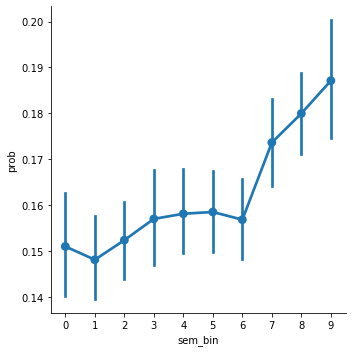

In [128]:
g = sns.catplot(x='sem_bin', y='prob', kind='point', 
                  data=pb_sem_crp1
           )

Split groups based on anxiety level (median split)

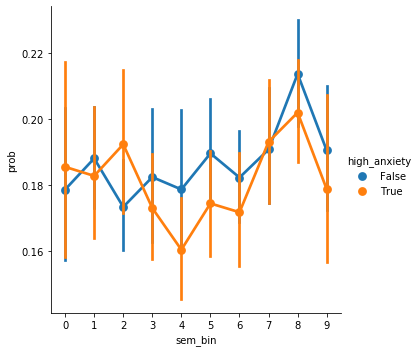

In [129]:
g = sns.catplot(x='sem_bin', y='prob', kind='point', hue='high_anxiety',
                  data=combined_sem_df
           )

Split groups based on depression level (median split)

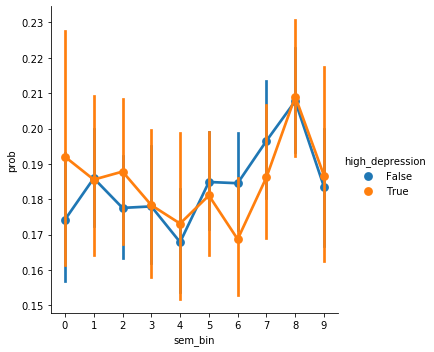

In [130]:
g = sns.catplot(x='sem_bin', y='prob', kind='point', hue='high_depression',
                  data=combined_sem_df
           )

all data

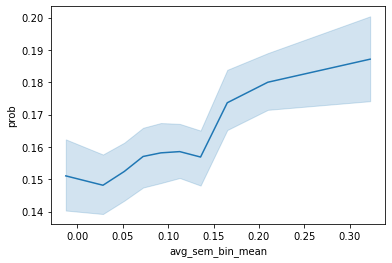

In [131]:
#using average bin value
pb_sem_crp1['avg_sem_bin_mean'] = pb_sem_crp1.groupby('sem_bin')['sem_bin_mean'].transform('mean')
g = sns.lineplot(x='avg_sem_bin_mean', y='prob', data=pb_sem_crp1)

split by group

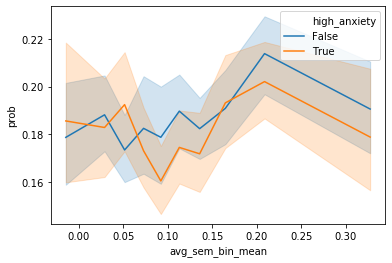

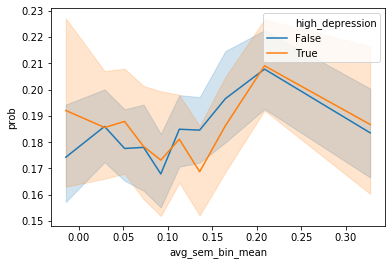

In [132]:
# combined_sem_df
combined_sem_df['avg_sem_bin_mean'] = combined_sem_df.groupby('sem_bin')['sem_bin_mean'].transform('mean')
combined_sem_df.head(5)
g = sns.lineplot(x='avg_sem_bin_mean', y='prob', hue = 'high_anxiety', data=combined_sem_df)
plt.figure(figsize=(6,4))
g = sns.lineplot(x='avg_sem_bin_mean', y='prob', hue = 'high_depression', data=combined_sem_df)

In [133]:
pb_sem_dist_fact = events_new.groupby(["subject","session"]).apply(pb.pd_dist_fact,
                                                       rec_itemnos=None, 
                                                       itemno_column='item_num_new', 
                                                       list_index=['subject', 'session', 'list'], 
                                                       dist_mat=sem_sims, 
                                                       sim_columns=None, 
                                                       is_similarity=True, 
                                                       dist_columns=None,
                                                       skip_first_n=0,
                                                       pres_type="WORD", rec_type="REC_WORD", type_column='type', ret_counts=False,
                                                       ).to_frame('sem_fact').reset_index()

pb_sem_dist_fact

,subject,session,sem_fact
0,R1001P,0,0.449928
1,R1001P,1,0.406337
2,R1002P,0,0.530847
3,R1002P,1,0.400478
4,R1003P,0,0.531164
...,...,...,...
566,R1565T,0,0.464103
567,R1569T,0,0.472451
568,R1571T,0,0.638596
569,R1572T,0,0.525595


#### combine semantic factor with BAI/BDI scores and demographic info

In [134]:

combined_sem_df=pd.merge(df_master[['BAI','BDI','subject','session','gender','IQ','age_of_seizure_onset','age_at_implant','binary_prior_neuro']], pb_sem_dist_fact, on=['subject','session'], how='right')
combined_sem_df = combined_sem_df.dropna(subset=['BAI','BDI','sem_fact'])
combined_sem_df


,BAI,BDI,subject,session,gender,IQ,age_of_seizure_onset,age_at_implant,binary_prior_neuro,sem_fact
0,8.0,2.0,R1001P,0.0,Female,72.0,20.0,48.105026,1.0,0.449928
1,8.0,2.0,R1001P,1.0,Female,72.0,20.0,48.105026,1.0,0.406337
2,9.0,0.0,R1002P,0.0,Female,86.0,34.0,49.383743,1.0,0.530847
3,9.0,0.0,R1002P,1.0,Female,86.0,34.0,49.383743,1.0,0.400478
6,7.0,7.0,R1006P,0.0,Female,83.0,18.0,20.553582,1.0,0.485324
...,...,...,...,...,...,...,...,...,...,...
747,2.0,7.0,R1542J,2.0,Male,114.0,22.0,29.281915,0.0,0.539262
748,2.0,7.0,R1542J,3.0,Male,114.0,22.0,29.281915,0.0,0.542918
749,2.0,7.0,R1542J,4.0,Male,114.0,22.0,29.281915,0.0,0.520232
750,2.0,7.0,R1542J,5.0,Male,114.0,22.0,29.281915,0.0,0.507870


#### Compute one-sample t-test to determine difference from 0¶

Add low/high depression/anxiety

In [135]:
# median
median_BAI=np.median(combined_sem_df['BAI'])
median_BDI=np.median(combined_sem_df['BDI'])
combined_sem_df['high_anxiety']=combined_sem_df['BAI']>median_BAI
combined_sem_df['high_depression']=combined_sem_df['BDI']>median_BDI

# or terciles:
low_BAI=np.percentile(combined_sem_df['BAI'],1/3*100)
low_BDI=np.percentile(combined_sem_df['BDI'],1/3*100)
upper_BAI=np.percentile(combined_sem_df['BAI'],2/3*100)
upper_BDI=np.percentile(combined_sem_df['BDI'],2/3*100)

# anxiety groups
combined_sem_df['anxiety_tercile']='mid'
low_BAI_index=combined_sem_df[combined_sem_df['BAI']<low_BAI].index
combined_sem_df['anxiety_tercile'][low_BAI_index]='low'
high_BAI_index=combined_sem_df[combined_sem_df['BAI']>upper_BAI].index
combined_sem_df['anxiety_tercile'][high_BAI_index]='high'

# depression groups
combined_sem_df['depression_tercile']='mid'
low_BDI_index=combined_sem_df[combined_sem_df['BDI']<low_BDI].index
combined_sem_df['depression_tercile'][low_BDI_index]='low'
high_BDI_index=combined_sem_df[combined_sem_df['BDI']>upper_BDI].index
combined_sem_df['depression_tercile'][high_BDI_index]='high'
combined_sem_df

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home1/noaherz/.conda

,BAI,BDI,subject,session,gender,IQ,age_of_seizure_onset,age_at_implant,binary_prior_neuro,sem_fact,high_anxiety,high_depression,anxiety_tercile,depression_tercile
0,8.0,2.0,R1001P,0.0,Female,72.0,20.0,48.105026,1.0,0.449928,True,False,mid,low
1,8.0,2.0,R1001P,1.0,Female,72.0,20.0,48.105026,1.0,0.406337,True,False,mid,low
2,9.0,0.0,R1002P,0.0,Female,86.0,34.0,49.383743,1.0,0.530847,True,False,mid,low
3,9.0,0.0,R1002P,1.0,Female,86.0,34.0,49.383743,1.0,0.400478,True,False,mid,low
6,7.0,7.0,R1006P,0.0,Female,83.0,18.0,20.553582,1.0,0.485324,False,False,mid,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,2.0,7.0,R1542J,2.0,Male,114.0,22.0,29.281915,0.0,0.539262,False,False,low,mid
748,2.0,7.0,R1542J,3.0,Male,114.0,22.0,29.281915,0.0,0.542918,False,False,low,mid
749,2.0,7.0,R1542J,4.0,Male,114.0,22.0,29.281915,0.0,0.520232,False,False,low,mid
750,2.0,7.0,R1542J,5.0,Male,114.0,22.0,29.281915,0.0,0.507870,False,False,low,mid


Average over sessions

In [136]:
mean_sem=combined_sem_df.groupby('subject')['sem_fact'].transform('mean') # avg over session within subjects
combined_sem_df['mean_temp'] = mean_sem
combined_sem_df

,BAI,BDI,subject,session,gender,IQ,age_of_seizure_onset,age_at_implant,binary_prior_neuro,sem_fact,high_anxiety,high_depression,anxiety_tercile,depression_tercile,mean_temp
0,8.0,2.0,R1001P,0.0,Female,72.0,20.0,48.105026,1.0,0.449928,True,False,mid,low,0.428133
1,8.0,2.0,R1001P,1.0,Female,72.0,20.0,48.105026,1.0,0.406337,True,False,mid,low,0.428133
2,9.0,0.0,R1002P,0.0,Female,86.0,34.0,49.383743,1.0,0.530847,True,False,mid,low,0.465663
3,9.0,0.0,R1002P,1.0,Female,86.0,34.0,49.383743,1.0,0.400478,True,False,mid,low,0.465663
6,7.0,7.0,R1006P,0.0,Female,83.0,18.0,20.553582,1.0,0.485324,False,False,mid,mid,0.533932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,2.0,7.0,R1542J,2.0,Male,114.0,22.0,29.281915,0.0,0.539262,False,False,low,mid,0.527309
748,2.0,7.0,R1542J,3.0,Male,114.0,22.0,29.281915,0.0,0.542918,False,False,low,mid,0.527309
749,2.0,7.0,R1542J,4.0,Male,114.0,22.0,29.281915,0.0,0.520232,False,False,low,mid,0.527309
750,2.0,7.0,R1542J,5.0,Male,114.0,22.0,29.281915,0.0,0.507870,False,False,low,mid,0.527309


leave only one value per perticipant

In [137]:
sub_level_df = pd.DataFrame([])
for sub in combined_sem_df['subject'].unique():
    sub_inf = combined_sem_df[combined_sem_df['subject']==sub]
    sub_level_df = sub_level_df.append({'subject':sub_inf['subject'].iloc[0],'high_anxiety':sub_inf['high_anxiety'].iloc[0],
                           'high_depression':sub_inf['high_depression'].iloc[0],'anxiety_tercile':sub_inf['anxiety_tercile'].iloc[0],
                                        'depression_tercile':sub_inf['depression_tercile'].iloc[0],'BDI':sub_inf['BDI'].iloc[0],
                                        'BAI':sub_inf['BAI'].iloc[0],'mean_temp':sub_inf['mean_temp'].iloc[0]},ignore_index=True)
sub_level_df

,BAI,BDI,anxiety_tercile,depression_tercile,high_anxiety,high_depression,mean_temp,subject
0,8.0,2.0,mid,low,1.0,0.0,0.428133,R1001P
1,9.0,0.0,mid,low,1.0,0.0,0.465663,R1002P
2,7.0,7.0,mid,mid,0.0,0.0,0.533932,R1006P
3,2.0,1.0,low,low,0.0,0.0,0.522230,R1010J
4,0.0,2.0,low,low,0.0,0.0,0.479752,R1018P
...,...,...,...,...,...,...,...,...
81,5.0,4.0,mid,low,0.0,0.0,0.564410,R1443D
82,6.0,0.0,mid,low,0.0,0.0,0.464074,R1457T
83,14.0,20.0,high,high,1.0,1.0,0.488302,R1466J
84,2.0,7.0,low,mid,0.0,0.0,0.527309,R1542J


#### Plot bar graph of semantic factor

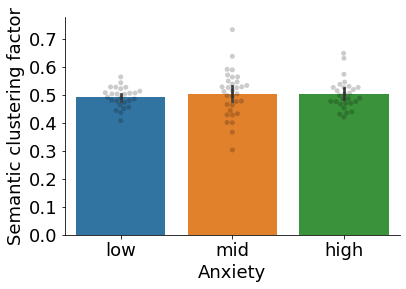

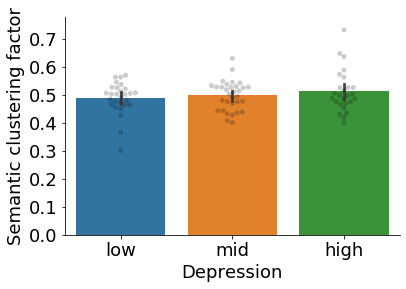

In [139]:
# Anxiety
plt.figure(figsize=(6,4))

# sort values
anxiety_terciles_categories = ['low','mid','high']
# Make "depression_tercile" a proper categorical column, specifying the categories and their order
sub_level_df["anxiety_tercile"] = pd.Categorical(sub_level_df["anxiety_tercile"], categories=anxiety_terciles_categories)

sub_level_df.sort_values(by = "anxiety_tercile",inplace=True, ascending = False) # sort categorized alphabetically
# Reset the index after sorting
sub_level_df.reset_index(drop=True, inplace=True)


sns.barplot(data = sub_level_df
            ,x = 'anxiety_tercile' ,y = 'mean_temp',order = ['low','mid','high'])
sns.swarmplot(data=sub_level_df,x = 'anxiety_tercile'
            ,y = 'mean_temp',color="0",alpha=.2)

# sns.swarmplot(data=combined_df,color="0",alpha=.4)
plt.ylabel('Semantic clustering factor',fontsize=18)
plt.xlabel('Anxiety',fontsize=18)
plt.xticks(fontsize=18);plt.yticks(fontsize=18)
# ax.set_ylim(-0.3, 0.4)
# sns.despine()
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['bottom'].set_color('k')

# Depression
plt.figure(figsize=(6,4))

# sort values
depression_terciles_categories = ['low','mid','high']
# Make "depression_tercile" a proper categorical column, specifying the categories and their order
sub_level_df["depression_tercile"] = pd.Categorical(sub_level_df["depression_tercile"], categories=depression_terciles_categories)

sub_level_df.sort_values(by = "depression_tercile",inplace=True, ascending = False) # sort categorized alphabetically
# Reset the index after sorting
sub_level_df.reset_index(drop=True, inplace=True)

#Plot
sns.barplot(data = sub_level_df
            ,x = 'depression_tercile' ,y = 'mean_temp',order = ['low','mid','high'])
sns.swarmplot(data=sub_level_df,x = 'depression_tercile'
            ,y = 'mean_temp',color="0",alpha=.2)

# sns.swarmplot(data=combined_df,color="0",alpha=.4)
plt.ylabel('Semantic clustering factor',fontsize=18)
plt.xlabel('Depression',fontsize=18)
plt.xticks(fontsize=18);plt.yticks(fontsize=18)
# ax.set_ylim(-0.3, 0.4)
# sns.despine()
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['bottom'].set_color('k')

#### Plot correlation between anxiety/depression and semantic factor

anxiety: r= 0.057895361780953766  p=  0.5964673229469034
depression: r= 0.06361857943102321  p=  0.5606129604469062


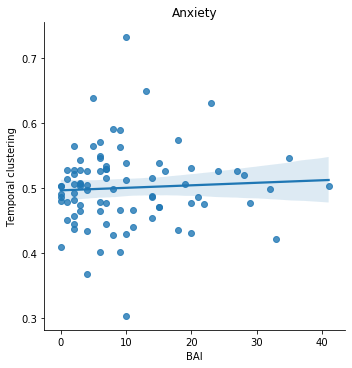

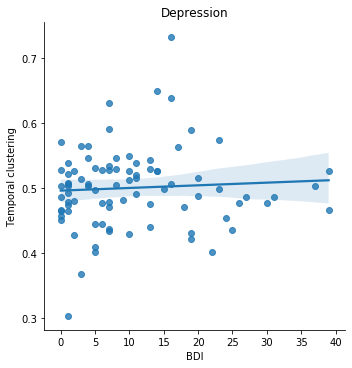

In [140]:
# anxiety
sns.lmplot(x="BAI", y="mean_temp", data=sub_level_df);
ax = plt.gca()
ax.set_title("Anxiety")
ax.set( xlabel = "BAI", ylabel = "Temporal clustering")

r, p= stats.pearsonr(sub_level_df['BAI'], sub_level_df['mean_temp'])
print('anxiety: r=', r, ' p= ',p)

# Depression
sns.lmplot(x="BDI", y="mean_temp", data=sub_level_df);
ax = plt.gca()
ax.set_title("Depression")
ax.set( xlabel = "BDI", ylabel = "Temporal clustering")

r, p= stats.pearsonr(sub_level_df['BDI'], sub_level_df['mean_temp'])
print('depression: r=', r, ' p= ',p)

## linear mixed effect, looking at the contribution of depression/anxiety to semantic clustering


In [142]:
vc = {'session': '0 + C(session)'} #the vc formula always varies within the groups parameter, so it will vary within subject 

## predict temporal factor:
model = sm.MixedLM.from_formula('sem_fact ~ 1',  vc_formula=vc, groups='subject', data=combined_sem_df) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

# depression - main effect ()
model = sm.MixedLM.from_formula('sem_fact ~ BDI ',vc_formula=vc, groups='subject', data=combined_sem_df) 
result=model.fit(reml=False, method='nm')
llf_BDI =result.llf #log likelihood
print(result.summary())

# # Likelihood ratio tests for depression
# print('Main effect of depression on sem_fact:')
# lr, p = lrtest(llf_empty, llf_BDI, df = 1) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
# print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))


# anxiety - main effect ()
model = sm.MixedLM.from_formula('sem_fact ~ BAI ',vc_formula=vc, groups='subject', data=combined_sem_df) 
result=model.fit(reml=False, method='nm')
llf_BAI =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for anxiety
print('Main effect of anxiety on sem_fact:')
lr, p = lrtest(llf_empty, llf_BAI, df = 1) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))

# demographis variables + depression - main effect ()
# binary_prior_neuro is 'True' when prior neuro procedure was NOT present, 'False' when any king of procedure WAS present 
model = sm.MixedLM.from_formula('sem_fact ~ BDI + BAI',vc_formula=vc, groups='subject', data=combined_sem_df) 
result=model.fit(reml=False, method='nm')
llf_Beck =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for depression
print('Main effect of depression and anxiety on sem_fact:')
lr, p = lrtest(llf_empty, llf_Beck, df = 2) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: sem_fact 
No. Observations: 259     Method:             ML       
No. Groups:       86      Scale:              0.0000   
Min. group size:  1       Log-Likelihood:     1389.8866
Max. group size:  10      Converged:          Yes      
Mean group size:  3.0                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   0.489      0.006 84.080 0.000  0.477  0.500
session Var 0.004 702935.467                           



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: sem_fact 
No. Observations: 259     Method:             ML       
No. Groups:       86      Scale:              0.0000   
Min. group size:  1       Log-Likelihood:     1389.8177
Max. group size:  10      Converged:          Yes      
Mean group size:  3.0                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   0.486      0.008 57.436 0.000  0.470  0.503
BDI         0.000      0.001  0.365 0.715 -0.001  0.001
session Var 0.004 700629.433                           



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: sem_fact 
No. Observations:  259     Method:             ML       
No. Groups:        86      Scale:              0.0000   
Min. group size:   1       Log-Likelihood:     1389.8946
Max. group size:   10      Converged:          Yes      
Mean group size:   3.0                                  
--------------------------------------------------------
            Coef.   Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    0.489      0.008 60.417 0.000  0.473  0.505
BAI         -0.000      0.001 -0.015 0.988 -0.001  0.001
session Var  0.004 703173.192                           

Main effect of anxiety on sem_fact:
LR test, p value: 0.0160, 0.899269411805403651172241552558
         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: sem_fact 
No. Observations:  259     Method:             ML       
No. Groups: 

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


#### add demographics into the model

In [143]:
demog_df = combined_sem_df.dropna(subset=['gender','binary_prior_neuro', 'age_at_implant', 'IQ'])
demog_df.head(5)


,BAI,BDI,subject,session,gender,IQ,age_of_seizure_onset,age_at_implant,binary_prior_neuro,sem_fact,high_anxiety,high_depression,anxiety_tercile,depression_tercile,mean_temp
0,8.0,2.0,R1001P,0.0,Female,72.0,20.0,48.105026,1.0,0.449928,True,False,mid,low,0.428133
1,8.0,2.0,R1001P,1.0,Female,72.0,20.0,48.105026,1.0,0.406337,True,False,mid,low,0.428133
2,9.0,0.0,R1002P,0.0,Female,86.0,34.0,49.383743,1.0,0.530847,True,False,mid,low,0.465663
3,9.0,0.0,R1002P,1.0,Female,86.0,34.0,49.383743,1.0,0.400478,True,False,mid,low,0.465663
6,7.0,7.0,R1006P,0.0,Female,83.0,18.0,20.553582,1.0,0.485324,False,False,mid,mid,0.533932


In [145]:
# vc = {'session': '0 + C(session)'} #the vc formula always varies within the groups parameter, so it will vary within subject 
import statsmodels.api as sm

## Total number of intrusions:
model = sm.MixedLM.from_formula('sem_fact ~ 1',  vc_formula=vc, groups='subject', data=demog_df) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

# demographis variables - main effect
# binary_prior_neuro is 'True' when prior neuro procedure was NOT present, 'False' when any kind of procedure WAS present 
model = sm.MixedLM.from_formula('sem_fact ~ C(gender)+C(binary_prior_neuro) + age_at_implant + IQ', vc_formula=vc, groups='subject', data=demog_df) 
result=model.fit(reml=False, method='nm')
llf_demog =result.llf #log likelihood
print(result.summary())

# # Likelihood ratio tests for main effects
# print('Main effect of demographics on sem_fact')
# lr, p = lrtest(llf_empty, llf_demog, df = 5) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
# print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))

# anxiety
model = sm.MixedLM.from_formula('sem_fact ~C(gender)+C(binary_prior_neuro) + age_at_implant + IQ + BAI', vc_formula=vc, groups='subject', data=demog_df) 
result=model.fit(reml=False, method='nm')
llf_demog_Beck =result.llf #log likelihood
print(result.summary())

# # Likelihood ratio tests for depression
# print('Main effect of anxiety on sem_fact, beyond other demographic variables:')
# lr, p = lrtest(llf_demog, llf_demog_Beck, df = 1) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
# print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))

# depression
model = sm.MixedLM.from_formula('sem_fact ~C(gender)+C(binary_prior_neuro) + age_at_implant + IQ + BDI', vc_formula=vc, groups='subject', data=demog_df) 
result=model.fit(reml=False, method='nm')
llf_demog_Beck =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for depression
print('Main effect of depression on sem_fact, beyond other demographic variables:')
lr, p = lrtest(llf_demog, llf_demog_Beck, df = 1) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.30f}'.format(lr, p))




/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: sem_fact 
No. Observations: 253     Method:             ML       
No. Groups:       83      Scale:              0.0000   
Min. group size:  1       Log-Likelihood:     1350.0683
Max. group size:  10      Converged:          Yes      
Mean group size:  3.0                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   0.487      0.006 82.506 0.000  0.476  0.499
session Var 0.004 718620.841                           



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       sem_fact 
No. Observations:       253           Method:                   ML       
No. Groups:             83            Scale:                    0.0000   
Min. group size:        1             Log-Likelihood:           1349.5314
Max. group size:        10            Converged:                Yes      
Mean group size:        3.0                                              
-------------------------------------------------------------------------
                             Coef.   Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     0.445      0.041 10.863 0.000  0.365  0.526
C(gender)[T.Male]            -0.001      0.011 -0.108 0.914 -0.022  0.020
C(binary_prior_neuro)[T.1.0] -0.001      0.013 -0.067 0.947 -0.027  0.025
age_at_implant               -0.000      0.001 -0.085 0.

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       sem_fact 
No. Observations:       253           Method:                   ML       
No. Groups:             83            Scale:                    0.0000   
Min. group size:        1             Log-Likelihood:           1349.5302
Max. group size:        10            Converged:                Yes      
Mean group size:        3.0                                              
-------------------------------------------------------------------------
                             Coef.   Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     0.445      0.041 10.831 0.000  0.365  0.526
C(gender)[T.Male]            -0.001      0.011 -0.108 0.914 -0.022  0.020
C(binary_prior_neuro)[T.1.0] -0.001      0.013 -0.066 0.947 -0.027  0.025
age_at_implant               -0.000      0.001 -0.084 0.

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
